In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, BatchNormalization, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import DenseNet201

import matplotlib.pyplot as plt
import seaborn as sns

## `-> Importing Dataset`

In [2]:
# !unzip /content/drive/MyDrive/hand-signs-dataset.zip # google colab

In [2]:
# data = '/content/dataset' # google colab
data = 'C:/Users/hp/Documents/GitHub/Prasunet_Company_projects/Prasunet_ML_05/food-101/images' # kaggle

In [3]:
classes = os.listdir(data)
print(classes)
print(f'Number of classes -> {len(classes)}')

['.DS_Store', 'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macaron

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/hp/Documents/GitHub/Prasunet_Company_projects/Prasunet_ML_05/food-101/images\\.DS_Store'

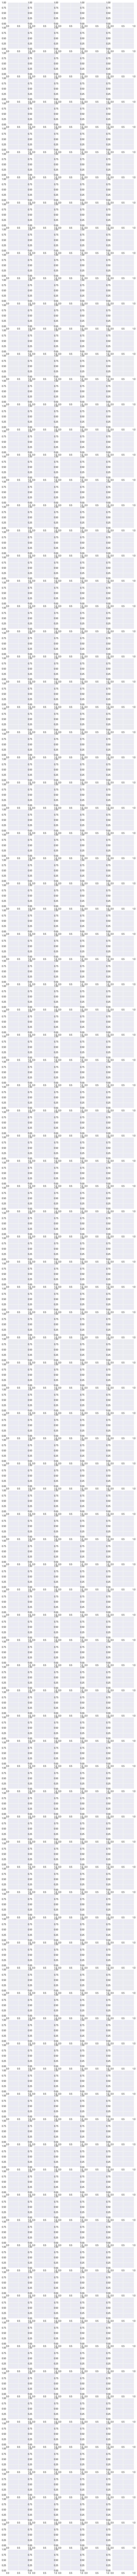

In [5]:
images_to_show = 5  
fig, ax = plt.subplots(nrows=len(classes), ncols=images_to_show, figsize=(images_to_show * 2, len(classes) * 2))

if len(classes) == 1:
    ax = [ax]

for index, class_ in enumerate(classes):
    images = os.listdir(os.path.join(data, class_))
    for i, image in enumerate(images[:images_to_show]):
        img = cv2.imread(os.path.join(data, class_, image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        ax[index, i].imshow(img, cmap = 'gray')
        ax[index, i].set_xlabel(class_)
        ax[index, i].set_xticks([])
        ax[index, i].set_yticks([])

plt.tight_layout()
plt.show()

In [6]:
images = []
labels = []

for label in os.listdir(data):
    class_images = os.listdir(os.path.join(data, label))
    for image in class_images:
        images.append((os.path.join(data, label, image)))
        labels.append(label)

In [7]:
dataset = pd.DataFrame({'Images' : images, 'Labels' : labels})
dataset.head()

,Images,Labels
0,/kaggle/input/food-101/dataset/macarons/242855...,macarons
1,/kaggle/input/food-101/dataset/macarons/384213...,macarons
2,/kaggle/input/food-101/dataset/macarons/196375...,macarons
3,/kaggle/input/food-101/dataset/macarons/1075.jpg,macarons
4,/kaggle/input/food-101/dataset/macarons/209441...,macarons


In [8]:
dataset['Labels'].value_counts()

Labels
french_fries         1000
macarons             1000
french_toast         1000
lobster_bisque       1000
prime_rib            1000
                     ... 
poutine              1000
hot_and_sour_soup    1000
seaweed_salad        1000
foie_gras            1000
waffles               999
Name: count, Length: 101, dtype: int64

## `2. Splitting the Dataset`

In [9]:
X_train, X_val = train_test_split(dataset, test_size = 0.2, random_state = 123, stratify=dataset['Labels'])

In [10]:
X_train.head()

,Images,Labels
61513,/kaggle/input/food-101/dataset/risotto/398282.jpg,risotto
99831,/kaggle/input/food-101/dataset/pad_thai/296987...,pad_thai
9719,/kaggle/input/food-101/dataset/poutine/2229390...,poutine
78071,/kaggle/input/food-101/dataset/sushi/2623508.jpg,sushi
58909,/kaggle/input/food-101/dataset/tiramisu/876899...,tiramisu


In [11]:
print(len(X_train['Labels']))
X_train['Labels'].value_counts()

80799


Labels
spaghetti_bolognese    800
risotto                800
pad_thai               800
poutine                800
sushi                  800
                      ... 
french_fries           800
greek_salad            800
french_toast           800
dumplings              800
waffles                799
Name: count, Length: 101, dtype: int64

In [12]:
X_val['Labels'].head()

72323      tuna_tartare
65756           churros
71991       greek_salad
65314           churros
2594     lobster_bisque
Name: Labels, dtype: object

In [13]:
print(len(X_val))
X_val['Labels'].value_counts()

20200


Labels
beignets               200
tuna_tartare           200
churros                200
greek_salad            200
lobster_bisque         200
                      ... 
spaghetti_carbonara    200
hamburger              200
french_toast           200
breakfast_burrito      200
falafel                200
Name: count, Length: 101, dtype: int64

## `3. Data Augmentation`

In [14]:
train_gen = ImageDataGenerator(rescale= 1 / 255.0,
                             zoom_range = 0.2,
                             rotation_range=30)

validation_gen = ImageDataGenerator(rescale = 1 / 255.0)

In [15]:
batch_size = 32

train_data = train_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col="Images",
                                           y_col='Labels',
                                           classes = classes,
                                           target_size = (224,224),
                                           color_mode = 'rgb',
                                           batch_size = batch_size,
                                           class_mode = 'sparse',
                                           shuffle = False)

valid_data = validation_gen.flow_from_dataframe(dataframe = X_val,
                                         x_col = 'Images',
                                         y_col = 'Labels',
                                        classes = classes,
                                        target_size = (224,224),
                                        color_mode = 'rgb',
                                        batch_size = batch_size,
                                        class_mode = 'sparse', shuffle = False)

Found 80799 validated image filenames belonging to 101 classes.
Found 20200 validated image filenames belonging to 101 classes.


In [16]:
def assigned_labels(data, classes, num_images=10):
    labels = set()
    count = 0
    
    for i in range(len(data)):
        images, labels_batch = data[i]
        
        for image, label in zip(images, labels_batch):
            if label not in labels:
                labels.add(label)
                count += 1
                
                plt.subplot(2, 5, count)
                plt.imshow(image, cmap='gray')
                plt.title(f'{label} - {classes[int(label)]}')
                plt.axis('off')
                
                if count == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

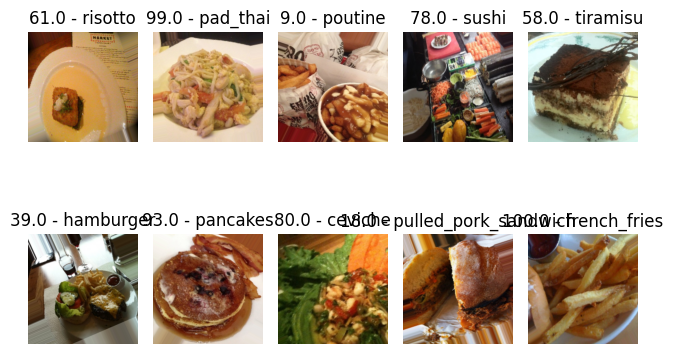

In [17]:
# show 10 labels
assigned_labels(train_data, classes)

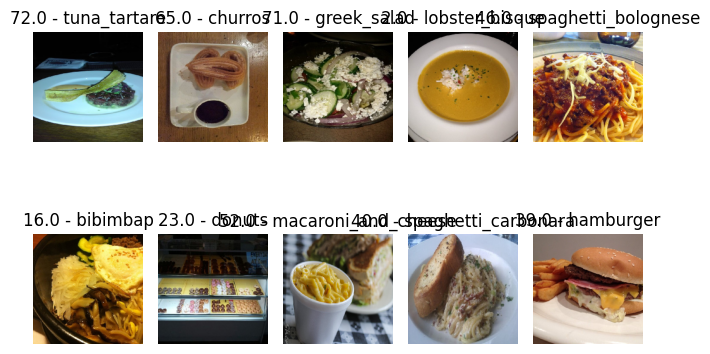

In [18]:
#to show 10 labels
assigned_labels(valid_data, classes)

In [19]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    pretrained_model = DenseNet201(include_top = False, input_shape=(224,224,3))

    model = Sequential([
        keras.Input(shape=(224,224,3)),
        pretrained_model,
        layers.GlobalAveragePooling2D(),
        Dense(101, activation = 'softmax')
    ])
    
    print(model.input_shape)
    print(model.output_shape)
    
    checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',        
    verbose=1,                 
    save_best_only=True,       
    mode='min'                 
    )
        
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    model.build((None, 224, 224, 3))

model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 224, 224, 3)
(None, 101)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       194,021 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,516,005 (70.63 MB)

 Trainable params: 18,286,949 (69.76 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [20]:
trained_model = model.fit(train_data, epochs = 10, validation_data=valid_data, steps_per_epoch=1750, callbacks = [checkpoint])

Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.3414 - loss: 2.9227
Epoch 1: val_loss improved from inf to 1.54624, saving model to best_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1574s 795ms/step - accuracy: 0.3415 - loss: 2.9223 - val_accuracy: 0.6003 - val_loss: 1.5462
Epoch 2/10
 775/1750 ━━━━━━━━━━━━━━━━━━━━ 11:10 688ms/step - accuracy: 0.6195 - loss: 1.4841
Epoch 2: val_loss improved from 1.54624 to 1.36898, saving model to best_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 613s 350ms/step - accuracy: 0.6230 - loss: 1.4642 - val_accuracy: 0.6448 - val_loss: 1.3690
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7209 - loss: 1.0779
Epoch 3: val_loss improved from 1.36898 to 1.29664, saving model to best_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1100s 626ms/step - accuracy: 0.7209 - loss: 1.0779 - val_accuracy: 0.6551 - val_loss: 1.2966
Epoch 4/10
 775/1750 ━━━━━━━━━━━━━━━━━━━━ 9:25 580ms/step - accuracy: 0.7198 - loss: 1.0822
Epoch 4: val_

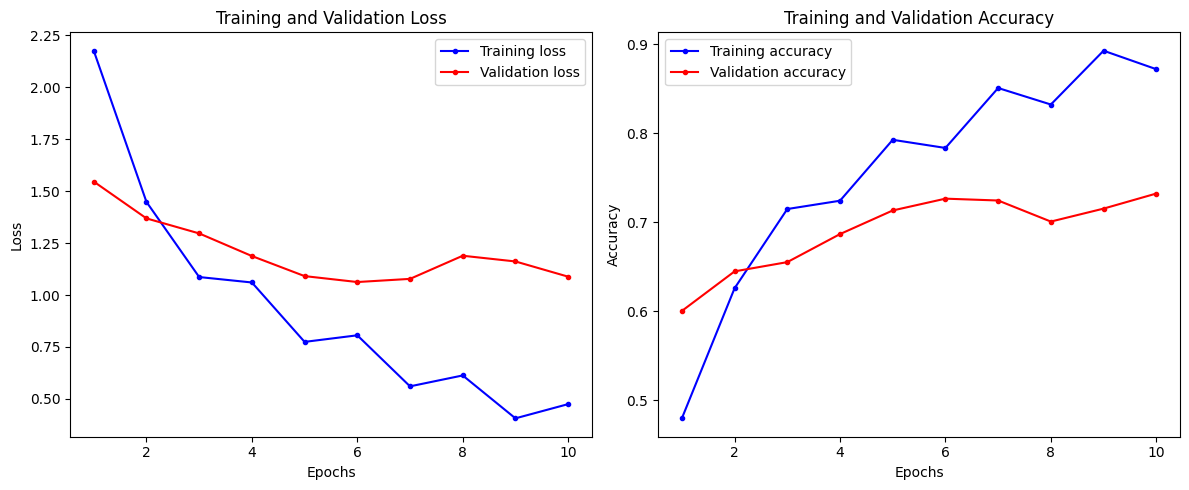

Accuracy -> 0.8926071524620056
Validation Accuracy -> 0.7321782112121582


In [21]:
history = trained_model.history
epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'b.-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r.-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'b.-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'r.-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Accuracy ->', max(trained_model.history['accuracy']))
print('Validation Accuracy ->', max(trained_model.history['val_accuracy']))

In [22]:
model.evaluate(valid_data)

632/632 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - accuracy: 0.7400 - loss: 1.0494


[1.0883357524871826, 0.7321782112121582]

In [23]:
pred = model.predict(valid_data)
pred = np.argmax(pred, axis=1)

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

632/632 ━━━━━━━━━━━━━━━━━━━━ 107s 149ms/step


In [24]:
y_test =  [labels[class_] for class_ in valid_data.classes]

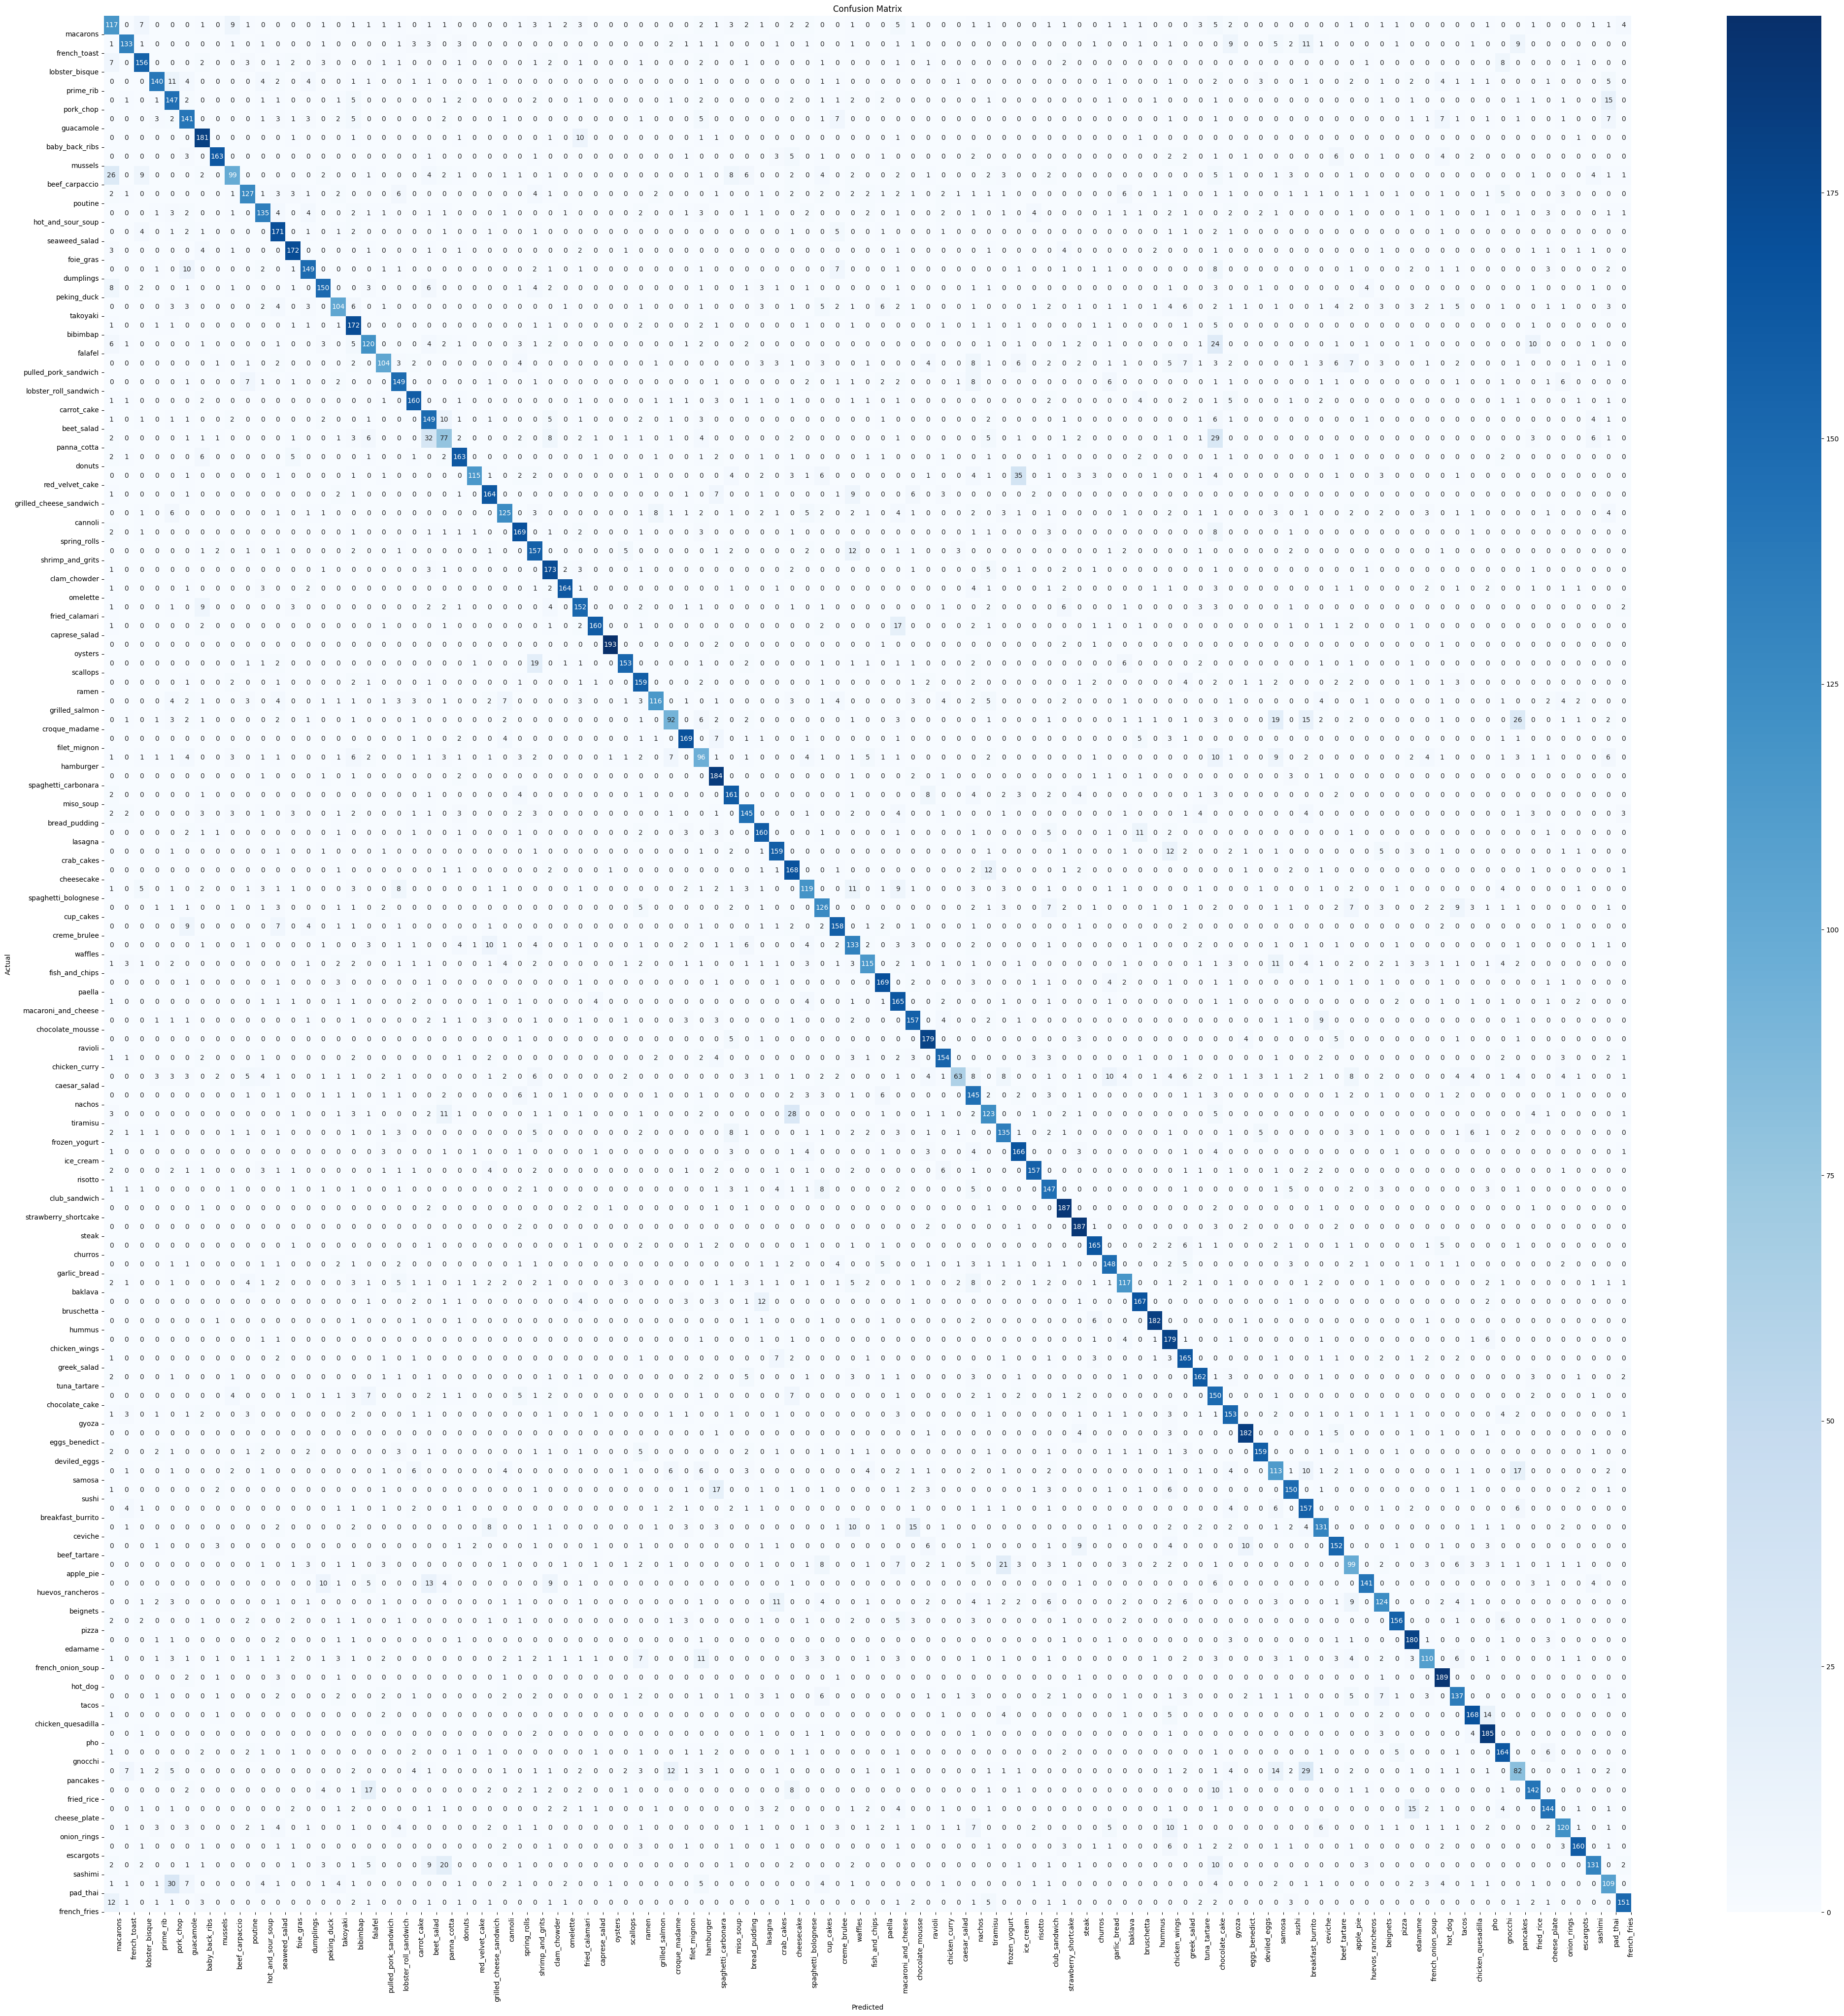

In [25]:
classes = ['macarons', 'french_toast', 'lobster_bisque', 'prime_rib', 'pork_chop', 'guacamole', 'baby_back_ribs', 'mussels', 'beef_carpaccio', 'poutine', 'hot_and_sour_soup', 'seaweed_salad', 'foie_gras', 'dumplings', 'peking_duck', 'takoyaki', 'bibimbap', 'falafel', 'pulled_pork_sandwich', 'lobster_roll_sandwich', 'carrot_cake', 'beet_salad', 'panna_cotta', 'donuts', 'red_velvet_cake', 'grilled_cheese_sandwich', 'cannoli', 'spring_rolls', 'shrimp_and_grits', 'clam_chowder', 'omelette', 'fried_calamari', 'caprese_salad', 'oysters', 'scallops', 'ramen', 'grilled_salmon', 'croque_madame', 'filet_mignon', 'hamburger', 'spaghetti_carbonara', 'miso_soup', 'bread_pudding', 'lasagna', 'crab_cakes', 'cheesecake', 'spaghetti_bolognese', 'cup_cakes', 'creme_brulee', 'waffles', 'fish_and_chips', 'paella', 'macaroni_and_cheese', 'chocolate_mousse', 'ravioli', 'chicken_curry', 'caesar_salad', 'nachos', 'tiramisu', 'frozen_yogurt', 'ice_cream', 'risotto', 'club_sandwich', 'strawberry_shortcake', 'steak', 'churros', 'garlic_bread', 'baklava', 'bruschetta', 'hummus', 'chicken_wings', 'greek_salad', 'tuna_tartare', 'chocolate_cake', 'gyoza', 'eggs_benedict', 'deviled_eggs', 'samosa', 'sushi', 'breakfast_burrito', 'ceviche', 'beef_tartare', 'apple_pie', 'huevos_rancheros', 'beignets', 'pizza', 'edamame', 'french_onion_soup', 'hot_dog', 'tacos', 'chicken_quesadilla', 'pho', 'gnocchi', 'pancakes', 'fried_rice', 'cheese_plate', 'onion_rings', 'escargots', 'sashimi', 'pad_thai', 'french_fries']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(50,50))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks = np.arange(1,102), labels=classes, rotation=90)
plt.yticks(ticks = np.arange(1,102), labels=classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

## `Exporting the model`

In [26]:
model.save('/kaggle/working/model_89A_73VA.h5')